<IPython.core.display.Javascript object>


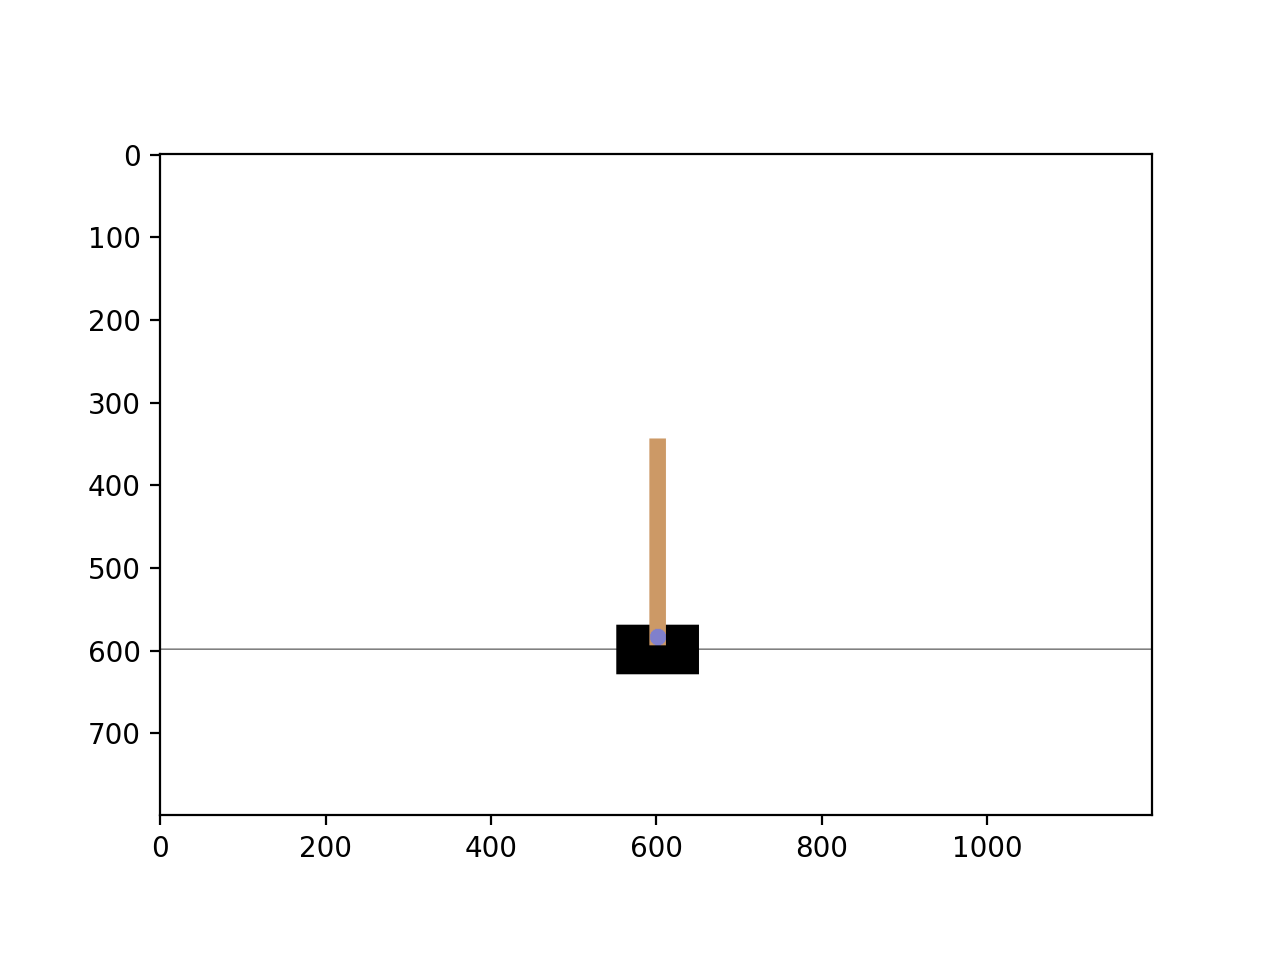

Button(description='<', style=ButtonStyle())

Button(description='>', style=ButtonStyle())

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import widgets
from IPython.display import display

import gym

from matplotlib import animation
from JSAnimation.IPython_display import display_animation



def leftclicked(something):
    """ Apply a force to the left of the cart"""
    onclick(0)

def rightclicked(something):
    """ Apply a force to the right of the cart"""
    onclick(1)
    
def display_buttons():
    """ Display the buttons you can use to apply a force to the cart """
    left = widgets.Button(description="<")
    right = widgets.Button(description=">")
    display(left, right)
    
    left.on_click(leftclicked)
    right.on_click(rightclicked)

# Create the environment and display the initial state
env = gym.make('CartPole-v0')
observation = env.reset()
firstframe = env.render(mode = 'rgb_array')
fig,ax = plt.subplots()
im = ax.imshow(firstframe) 

# Show the buttons to control the cart
display_buttons()


# Function that defines what happens when you click one of the buttons
frames = []
def onclick(action):
    global frames
    observation, reward, done, info = env.step(action)
    frame = env.render(mode = 'rgb_array')
    im.set_data(frame)
    frames.append(frame)
    if done:
        env.reset()

<IPython.core.display.Javascript object>


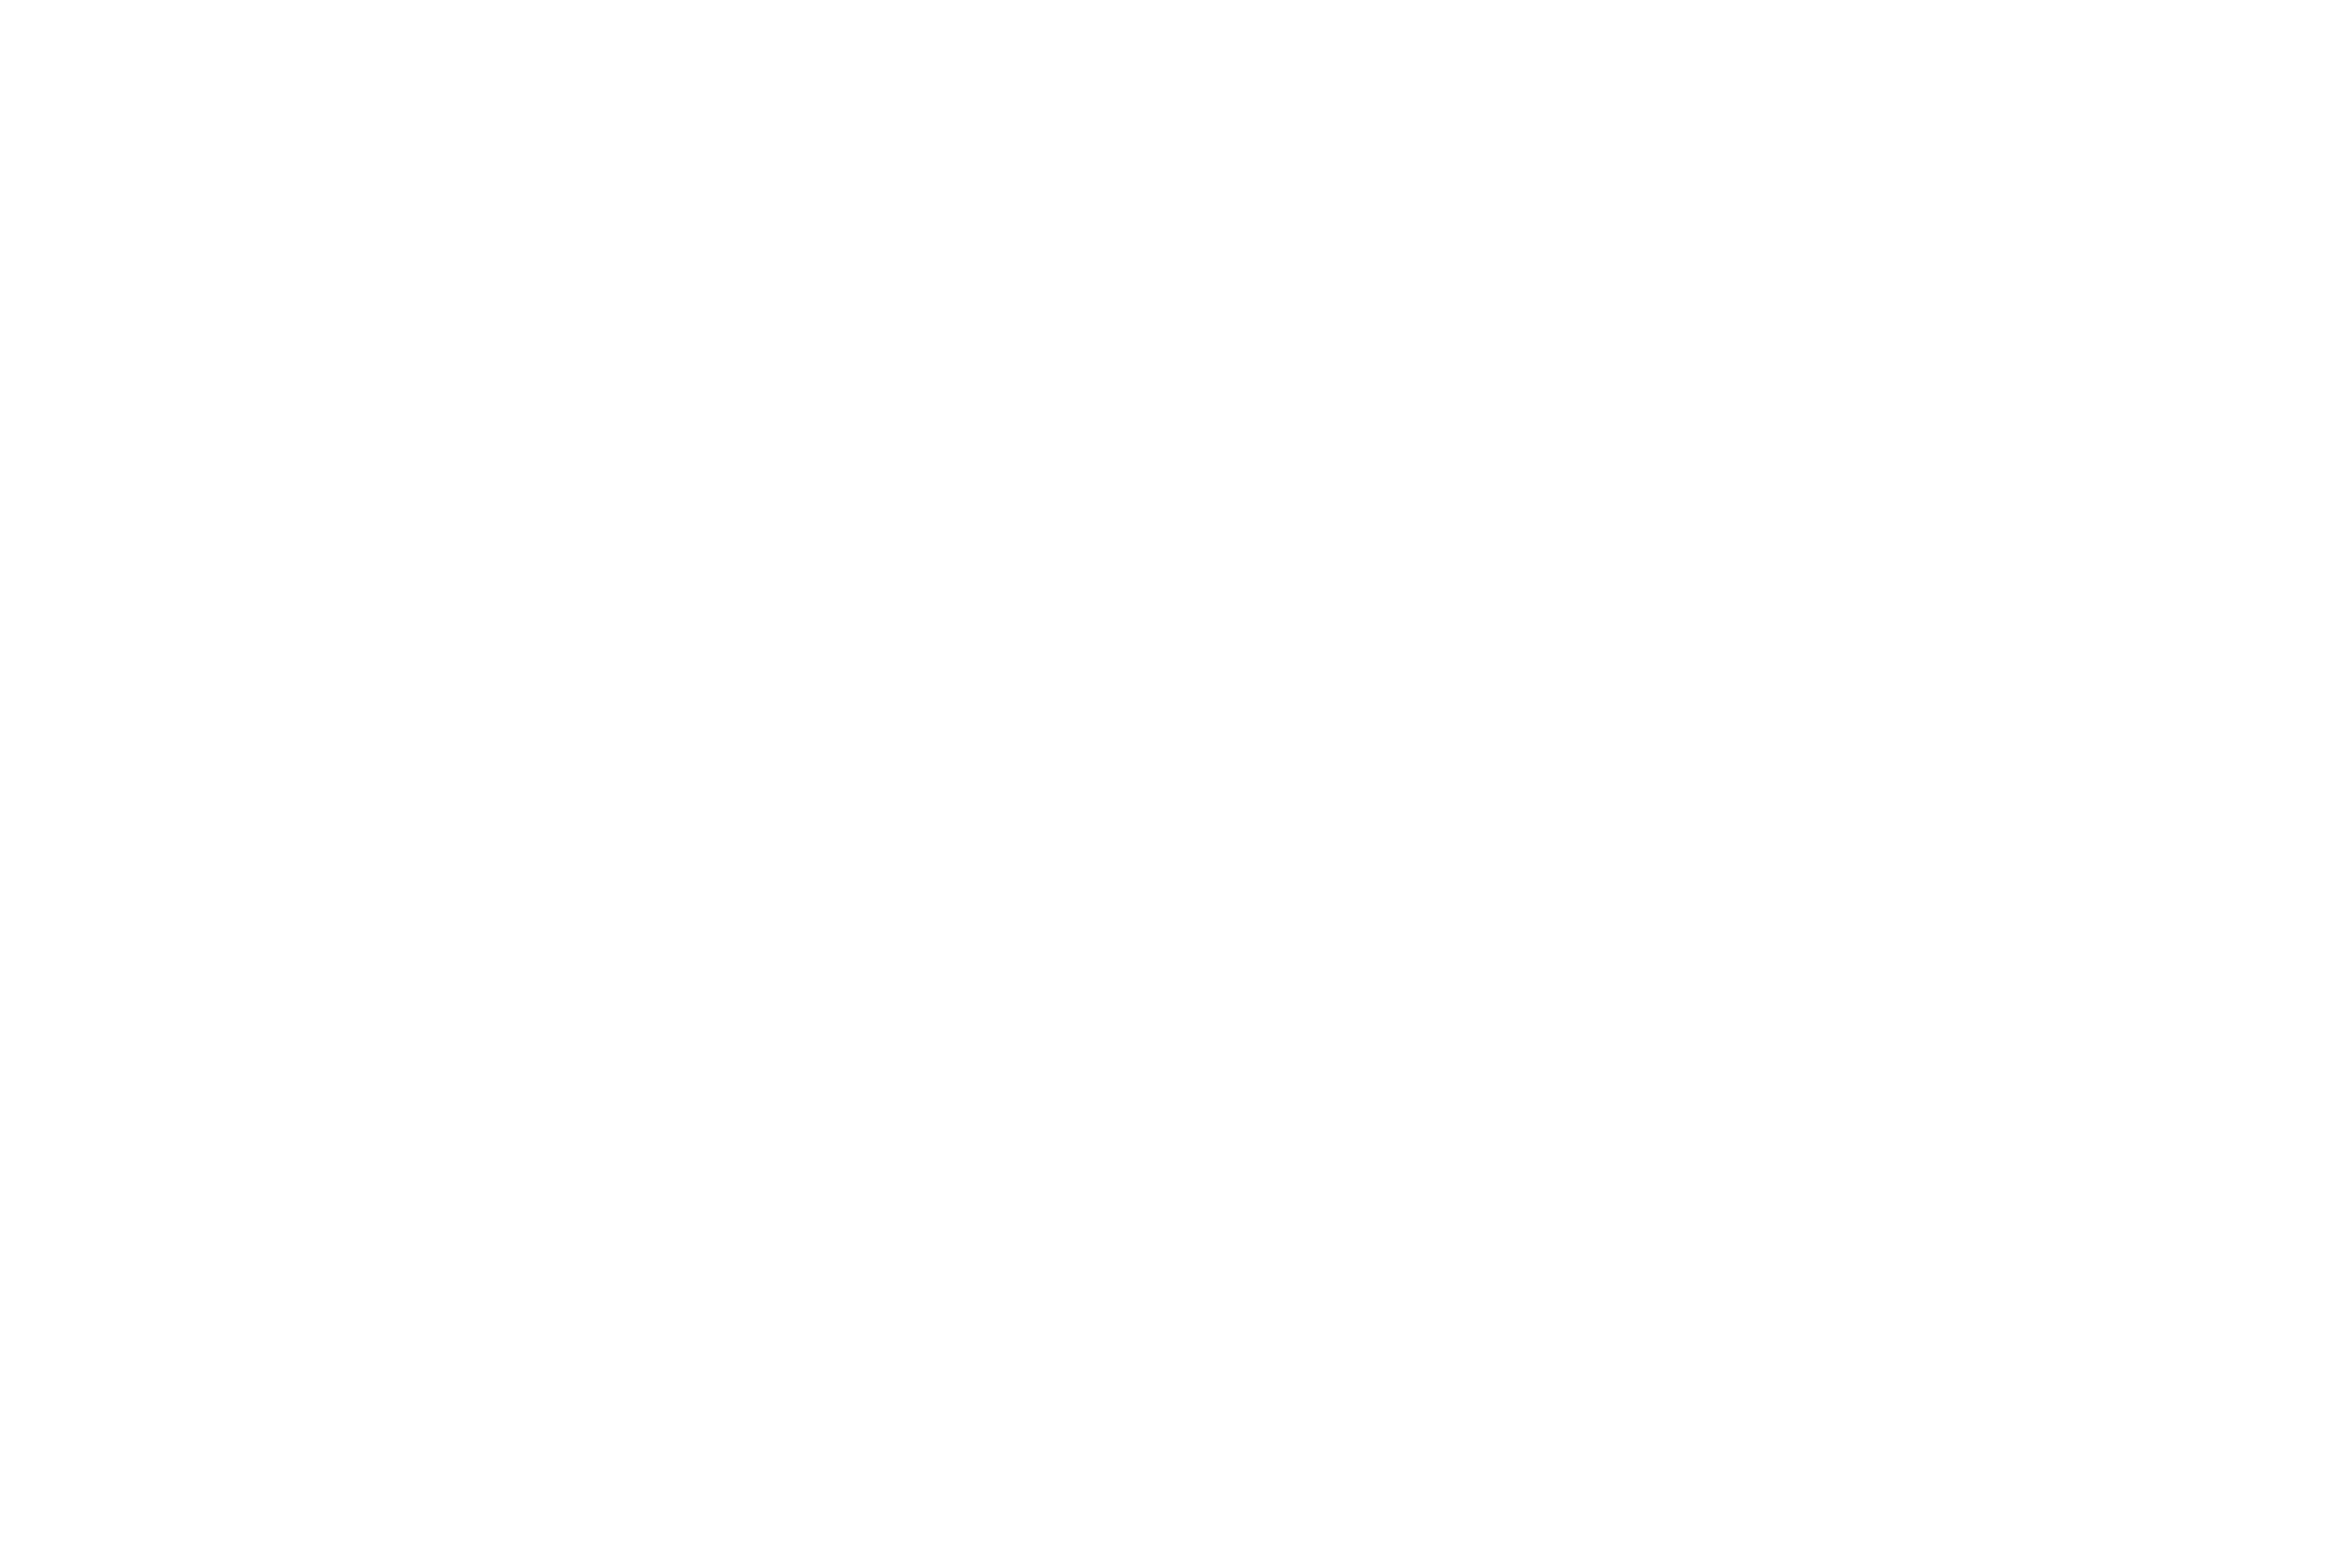

AttributeError: 'HTMLWriter' object has no attribute '_temp_names'

In [3]:
def display_frames_as_gif(frames, filename_gif = None):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    if filename_gif: 
        anim.save(filename_gif, writer = 'pillow', fps=20)
    display(display_animation(anim, default_mode='loop'))

display_frames_as_gif(frames, filename_gif="manualplay.gif")

<IPython.core.display.Javascript object>


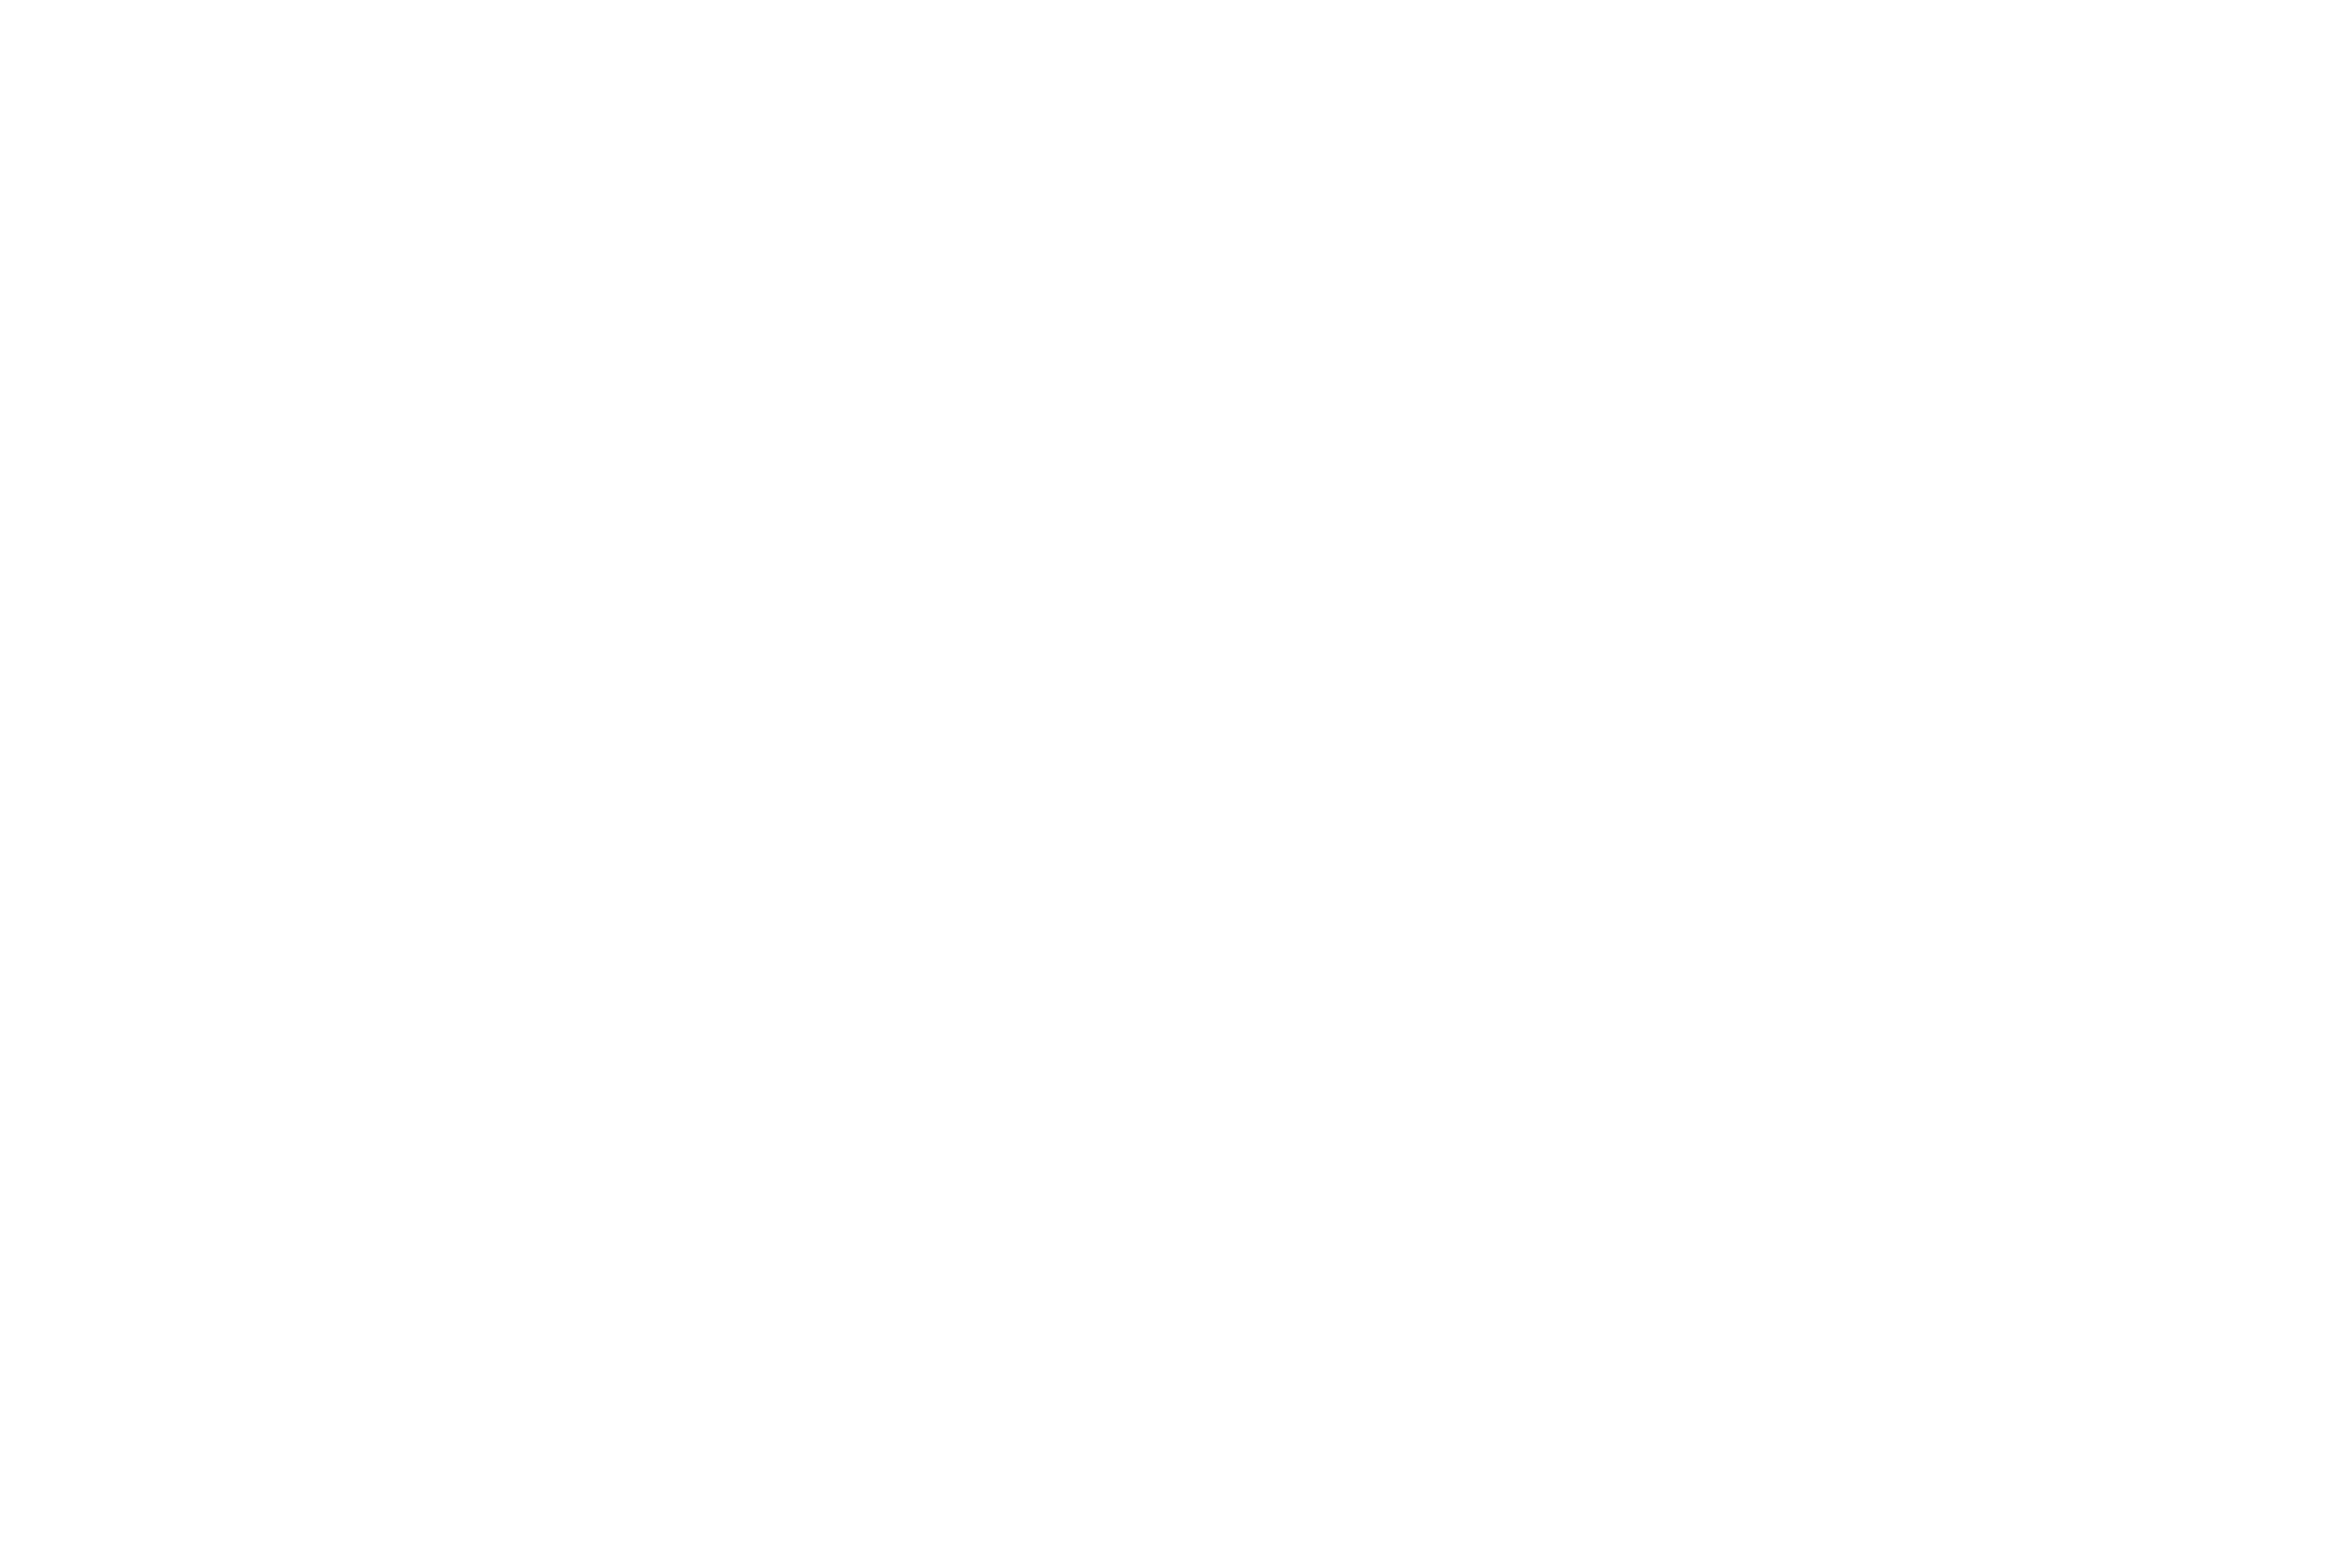

AttributeError: 'HTMLWriter' object has no attribute '_temp_names'

In [5]:
def run_episode(env, parameters):  
    """Runs the env for a certain amount of steps with the given parameters. Returns the reward obtained"""
    observation = env.reset()
    totalreward = 0
    for _ in range(200):
        action = 0 if np.matmul(parameters,observation) < 0 else 1
        observation, reward, done, info = env.step(action)
        totalreward += reward
        if done:
            break
    return totalreward

# Random search: try random parameters between -1 and 1, see how long the game lasts with those parameters
bestparams = None  
bestreward = 0  
for _ in range(10000):  
    parameters = np.random.rand(4) * 2 - 1
    reward = run_episode(env,parameters)
    if reward > bestreward:
        bestreward = reward
        bestparams = parameters
        # considered solved if the agent lasts 200 timesteps
        if reward == 200:
            break
            
def show_episode(env, parameters):  
    """ Records the frames of the environment obtained using the given parameters... Returns RGB frames"""
    observation = env.reset()
    firstframe = env.render(mode = 'rgb_array')
    frames = [firstframe]
    
    for _ in range(200):
        action = 0 if np.matmul(parameters,observation) < 0 else 1
        observation, reward, done, info = env.step(action)
        frame = env.render(mode = 'rgb_array')
        frames.append(frame)
        if done:
            break
    return frames

frames = show_episode(env, bestparams)
display_frames_as_gif(frames, filename_gif="bestresultrandom.gif")